# Assignment 1 - LS on 2nd order polynomial

First, we will define the necessary functions and objects to carry out task 1.4. Then, we will examine each sub-case in task 1.4. 

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm
from typing import Callable

In [2]:
def arbitrary_poly(params: list) -> Callable:
    """
    Takes the parameters in params and makes them into a polynomial 
        theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
    where n is model order and theta_0 is bias. 
    Args:
        params: list on format [theta_0, theta_1, theta_2, ..., theta_n]
    Returns:
        Function with single argument x. 
    """
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


In [3]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))


## Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P_N(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P_L(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Mixture model: $P(x) = \alpha P_N(x) + (1-\alpha) P_L(x)$


In [4]:
def generate_noise(N: int, magnitude: float, alpha: float, gauss_params: GaussParams, laplace_params: LaplaceParams) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: fraction of guassian and laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
    Returns:
        A list of N noise points.
    """
    if alpha == 1:
        noise = np.random.normal(*gauss_params, N)
    elif alpha == 0:
        noise = np.random.laplace(*laplace_params, N)
    else:
        noise = alpha * np.random.normal(*gauss_params, N) + \
                (1 - alpha) * np.random.laplace(*laplace_params, N)
    noise *= magnitude

    return noise

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

&nbsp;

### Step 1 - rewrite the model in matrix form to get the data tensor u

$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$


### Step 3  

calculating dot productcalculate $(\mathbf{u}^T \cdot \mathbf{y})$


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$



In [5]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [6]:
def ls_statistics(
    u: np.ndarray,
    y: np.ndarray, 
    true_params: np.ndarray, 
    ls_params_estimate: np.ndarray) -> tuple:
    """
    Calculate statistics on LS performance. 
    Args:
        u: data points x value.
        y: measured data points (with noise).
        true_params: list of the true parameters.
        ls_params_estimate: list of the LS parameters estimates.
    Returns:
        Tuple on the form 
            (RMSE, d) 
        where d is the Euclidean distance between the true and estimated parameters.
    """
    ls_model = arbitrary_poly(ls_params_estimate)
    rmse = np.sqrt(np.mean( (ls_model(u) - y)**2 ))
    d = np.linalg.norm( ls_params_estimate - np.array(true_params) )

    return rmse, d


In [7]:
def plot_mixture_distribution(alpha: float, gp: GaussParams, lp: LaplaceParams):
    # The Laplace probability density function: available in library "scipy.stats.laplace"
    # The Gaussian probability density function: available in library "scipy.stats.norm"
    def mixture_pdf(x):
        return alpha * norm.pdf(x, *gp) + (1-alpha) * laplace.pdf(x, *lp)

    # Plot noise distribution
    loc = alpha * gp.loc + (1-alpha) * lp.loc
    scale = alpha * gp.scale + (1-alpha) * lp.scale
    n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf

    fig, ax = plt.subplots()
    ax.plot(n, mixture_pdf(n))
    ax.set_title(f"Gaussian (m={gp.mean}, std={gp.std}) and Laplace (m={lp.mean}, beta={lp.beta}) mixture model, alpha = {alpha}")
    plt.tight_layout()
    plt.show()


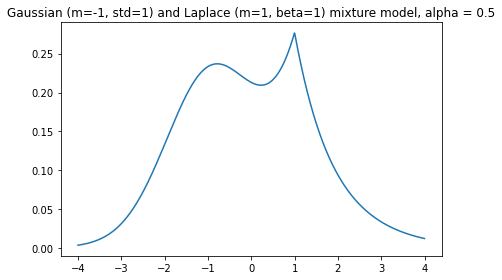

In [8]:
# Illustrate mixture
gp = GaussParams(-1, 1)
lp = LaplaceParams(1, 1)
alpha = 0.5
plot_mixture_distribution(alpha, gp, lp)


The above plot is only for illustrative purposes and does not resemble any actual noise distribution. 

## Task 1.4: Set up global parameters for each case

In [9]:
# True model
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 20           # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low, range_high, N))
y_true = y_model(u)

## Case 1: $\alpha = 1$ and $\sigma$ is varying

In [21]:
# Parameters
alpha = 1

# Add noise to the generated data points - thus simulating measurement
ls_data = []
for std in [0.2, 0.5, 1, 2, 5]:
    np.random.seed(0)
    noise = generate_noise(N, magnitude, alpha, GaussParams(0, std), None)
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((std, ls_params, y, d))


Euclidean distance d for different sigma:
  sigma = 0.2 --> d = 0.2236 	(params: [ 1.1706716  -8.14042545  3.96639738])
  sigma = 0.5 --> d = 0.5589 	(params: [ 1.42667901 -8.35106364  3.91599345])
  sigma = 1.0 --> d = 1.1178 	(params: [ 1.85335801 -8.70212727  3.83198689])
  sigma = 2.0 --> d = 2.2356 	(params: [ 2.70671602 -9.40425454  3.66397378])
  sigma = 5.0 --> d = 5.5889 	(params: [  5.26679006 -11.51063636   3.15993446])



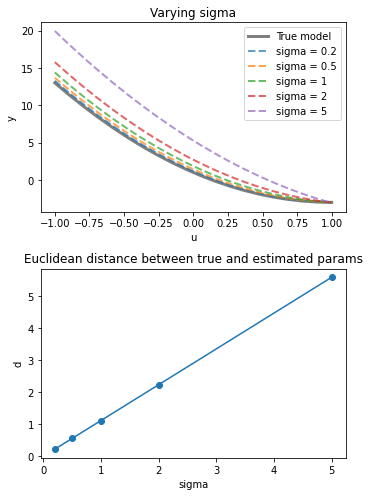

In [22]:
# Plot
plt.figure(figsize=(5,7))

plt.subplot(211)
x = np.linspace(range_low, range_high, N)
plt.plot(x, y_model(x), "k", alpha=0.5, lw=3, label="True model")
for std, params, y, d in ls_data:
    ls_mod = arbitrary_poly(params)
    plt.plot(x, ls_mod(x), "--", alpha=0.7, lw=2, label=f"sigma = {std}")
plt.legend()
plt.title("Varying sigma")
plt.xlabel("u")
plt.ylabel("y")

plt.subplot(212)
stds, ds = [], []
print("Euclidean distance d for different sigma:")
for std, params, y, d in ls_data:
    stds.append(std)
    ds.append(d)
    print(f"  sigma = {std:1.1f} --> d = {d:.4f} \t(params: {params})")
print()
plt.plot(stds, ds)
plt.scatter(stds, ds)
plt.xlabel("sigma")
plt.ylabel("d")
plt.title("Euclidean distance between true and estimated params")

plt.tight_layout(h_pad=1)
plt.show()


### Comments to case 1 TODO

The $\sigma$ parameter is the standard deviation of the Gaussian distribution, and determines how "wide" or "spread out" the distribution is. Larger $\sigma$ means wider distribution. 

We see the largest error both in the graph and in the table when $\sigma$ is large. This is expected behavior as a large $\sigma$ indicates large uncertainty in the measured data. 

An interesting note is that all models for each $\sigma$ tried above intersect in $u = 1.0$. This could be entirely coincidental 

## Case 2: $\alpha = 0$ and $\beta$ is varying

In [17]:
# Parameters
alpha = 0

# Add noise to the generated data points - thus simulating measurement
ls_data = []
for beta in [0.2, 0.5, 1, 2, 5]:
    np.random.seed(0)
    noise = generate_noise(N, magnitude, alpha, None, LaplaceParams(0, beta))
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((beta, ls_params, y, d))

Euclidean distance d for different betas:
  beta = 0.2 --> d = 0.1536 	(params: [ 1.09508946 -8.06898247  3.90106484])
  beta = 0.5 --> d = 0.3840 	(params: [ 1.23772365 -8.17245619  3.75266211])
  beta = 1.0 --> d = 0.7679 	(params: [ 1.47544731 -8.34491237  3.50532422])
  beta = 2.0 --> d = 1.5359 	(params: [ 1.95089462 -8.68982474  3.01064844])
  beta = 5.0 --> d = 3.8397 	(params: [ 3.37723654 -9.72456185  1.52662109])



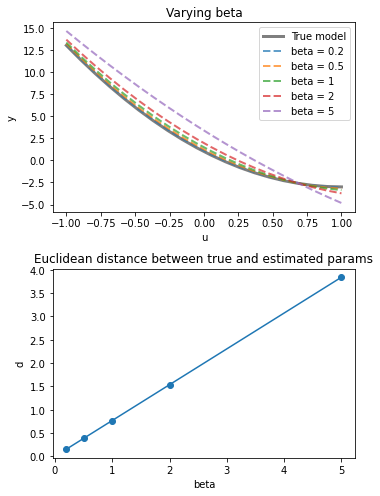

In [20]:
# Plot 
plt.figure(figsize=(5,7))

plt.subplot(211)
x = np.linspace(range_low, range_high, N)
plt.plot(x, y_model(x), "k", alpha=0.5, lw=3, label="True model")
for beta, params, y, d in ls_data:
    ls_mod = arbitrary_poly(params)
    plt.plot(x, ls_mod(x), "--", alpha=0.7, lw=2, label=f"beta = {beta}")
plt.legend()
plt.title("Varying beta")
plt.xlabel("u")
plt.ylabel("y")

plt.subplot(212)
betas, ds = [], []
print("Euclidean distance d for different betas:")
for beta, params, y, d in ls_data:
    betas.append(beta)
    ds.append(d)
    print(f"  beta = {beta:1.1f} --> d = {d:.4f} \t(params: {params})")
print()
plt.plot(betas, ds)
plt.scatter(betas, ds)
plt.xlabel("beta")
plt.ylabel("d")
plt.title("Euclidean distance between true and estimated params")

plt.tight_layout(h_pad=1)
plt.show()



### Comments to case 2 TODO

Similar to the Gaussian, the $\beta$ parameters in the Laplacian distribution determines how "wide" the distribution is. Larger $\beta$ leads to wider distribution. Likewise as in the Gaussian case above, we see that the distance between the true and estimated paramters increase with increased $\beta$ (i.e. wider distribution). 

It looks like there is a linear relationship between the distanc between the true and estimated parameters, and $\beta$. However, it is hard to verify if this is actually the case due to the small number of $\beta$'s tried. 

An interesting note is that when $\beta = 5$ the model found using LS looks almost linear in our interval $[-1, 1]$. In fact, the $\theta_2$ parameter is less than half of what the true parameter is ($1.5$ vs $4$, respectively). This was not observed with pure Gaussian noise. 



## Case 3: $\sigma = \beta = 1$ and $\alpha$ is varying

In [14]:
# Parameters
gp = GaussParams(0, 1)
lp = LaplaceParams(0, 1)

# Add noise to the generated data points - thus simulating measurement
ls_data = []
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    np.random.seed(0)
    noise = generate_noise(N, magnitude, alpha, gp, lp)
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((alpha, ls_params, y, d))

Euclidean distance d for different alphas:
  alpha = 0.1 --> d = 0.2955
  alpha = 0.3 --> d = 0.3693
  alpha = 0.5 --> d = 0.5523
  alpha = 0.7 --> d = 0.7701
  alpha = 0.9 --> d = 1.0004



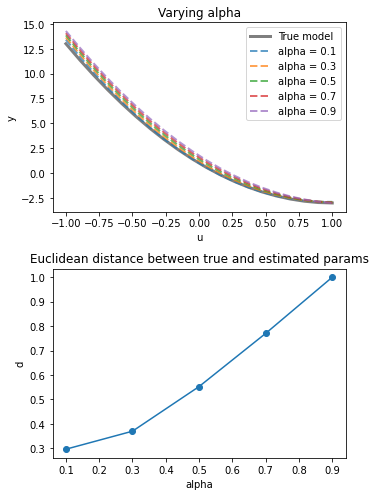

In [15]:
# Plot 
plt.figure(figsize=(5,7))

plt.subplot(211)
x = np.linspace(range_low, range_high, N)
plt.plot(x, y_model(x), "k", alpha=0.5, lw=3, label="True model")
for alpha, params, y, d in ls_data:
    ls_mod = arbitrary_poly(params)
    plt.plot(x, ls_mod(x), "--", alpha=0.7, lw=2, label=f"alpha = {alpha}")
plt.legend()
plt.title("Varying alpha")
plt.xlabel("u")
plt.ylabel("y")

plt.subplot(212)
alphas, ds = [], []
print("Euclidean distance d for different alphas:")
for alpha, params, y, d in ls_data:
    alphas.append(alpha)
    ds.append(d)
    print(f"  alpha = {alpha:1.1f} --> d = {d:.4f} \t(params: {params})")
print()
plt.plot(alphas, ds)
plt.scatter(alphas, ds)
plt.xlabel("alpha")
plt.ylabel("d")
plt.title("Euclidean distance between true and estimated params")

plt.tight_layout(h_pad=1)
plt.show()


### Comments to case 3 TODO

Notice the changed scale on the y-axis of the distance plot. 

## General comments to all cases TODO

LS does not account for the statistical properties such as MLE does. 

In this experiment we used a relatively small sample size of $N = 20$. We saw when varying $\sigma$ and $\beta$ that these parameters had greater effect on the distance between the true and estimated parameters than varying $\alpha$ did. However, it could be the case that if we were to increase the sample size we would see better performance with larger $\sigma$ and/or $\beta$. 
